In [13]:
import time 
import pickle 
import logging 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from joblib import dump, load


from sklearn import metrics
from sklearn.utils import shuffle, class_weight 
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate 
from sklearn.impute import KNNImputer 
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline

pd.options.display.float_format = '{:20,.15f}'.format 
pd.options.display.max_columns = None

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout 
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier 
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.optimizers import Adamax 
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical
from tensorflow.compat.v1.keras import backend as K

tf.autograph.set_verbosity(1) 
tf.get_logger().setLevel(logging.ERROR) 
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=8, inter_op_parallelism_threads=8)
session_conf.gpu_options.per_process_gpu_memory_fraction = 0.5
K.set_session(tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf))

from hyperopt import Trials, STATUS_OK, tpe, rand 
from hyperas import optim 
from hyperas.distributions import choice, uniform

from bayes_opt import BayesianOptimization, SequentialDomainReductionTransformer

plt.rcParams["figure.figsize"] = (7,3)

In [14]:
from importlib import reload
import binary_output, run_models, output, multiclass_output
from binary_output import (
    calc_binary_metrics, calc_confusion_values, get_binary_metrics_for_threshold, get_binary_cv_metrics, get_print_binary_metrics,
    keras_error_rate, keras_matthews_correlation, keras_f1_score, keras_conf_matrix)
from run_models import get_classification_cv_predictions
from output import print_train_history, print_formatted, print_output, print_formatted_params
from multiclass_output import print_conf_matrix, get_avg_cm, get_avg_cm_df, get_cv_avg_one_away_accuracy, get_cv_avg_one_away_accuracy_per_class, get_multiclass_metrics, get_cv_multiclass_metrics
reload(binary_output)
reload(output)
reload(run_models)
reload(multiclass_output)
from binary_output import (
    calc_binary_metrics, calc_confusion_values, get_binary_metrics_for_threshold, get_binary_cv_metrics, get_print_binary_metrics,
    keras_error_rate, keras_matthews_correlation, keras_f1_score, keras_conf_matrix)
from run_models import get_classification_cv_predictions
from output import print_train_history, print_formatted, print_output, print_formatted_params
from multiclass_output import print_conf_matrix, get_avg_cm, get_avg_cm_df, get_cv_avg_one_away_accuracy, get_cv_avg_one_away_accuracy_per_class, get_multiclass_metrics, get_cv_multiclass_metrics

In [3]:
with open(f'classification/multi_data_dropped_nan_filled.pickle', 'rb') as handle:
    data = pickle.load(handle)

X_train, y_train, X_val, y_val, X_test, y_test = data['X_train'], data['y_train'], data['X_val'], data['y_val'], data['X_test'], data['y_test']
X = pd.concat([X_train, X_test, X_val])
y = np.concatenate([y_train, y_test, y_val])

In [4]:
def create_nn(input_shape):
    def get_model():
        model = tf.keras.Sequential()
        model.add(Dense(1024, input_shape=input_shape, activation='tanh'))
        model.add(Dropout(0.5))
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(192, activation='elu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(
            loss=tf.keras.losses.BinaryCrossentropy(reduction='none', label_smoothing=0.02),
            metrics=[
                keras_f1_score,
                keras_matthews_correlation,
                tf.keras.metrics.TruePositives(name='tp'),
                tf.keras.metrics.TrueNegatives(name='tn'),
                tf.keras.metrics.FalsePositives(name='fp'),
                tf.keras.metrics.FalseNegatives(name='fn'),
                tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                keras_error_rate,
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc'),
            ],
            optimizer='adamax',
        )
        return model
    return get_model

def fit_nn(model, X, y, X_val=None, y_val=None, patience=30, verbose=0):
    es = EarlyStopping(monitor='val_auc', mode='max', verbose=1, patience=patience)

    counts = np.bincount(y)
    class_weights = {0: 1.0 / counts[0], 1: 1.0 / counts[1]}

    fit_params = {
        'batch_size': 512,
        'epochs': 10000,
        'verbose': verbose,
        'shuffle': True,
        'class_weight': class_weights,
        'callbacks': [es],
        'use_multiprocessing': True,
    }
    eval_set = (X_val, y_val) if not X_val.empty and y_val.any() else None
    if eval_set:
        fit_params['validation_data'] = eval_set
    else:
        fit_params['validation_split'] = 0.05
    history = model.fit(X, y, **fit_params)
    return model, history

def create_and_fit_nn(X, y, X_val=None, y_val=None, patience=100, model_params={}, verbose=0):
    return fit_nn(create_nn(input_shape=[X.shape[1]])(), X, y, X_val, y_val, patience=patience, verbose=verbose)

def create_and_fit_nn_pipe(X, y, X_val=None, y_val=None, patience=100, model_params={}, verbose=0):
    es = EarlyStopping(monitor='val_auc', mode='max', verbose=1, patience=patience)
    counts = np.bincount(y)
    class_weights = {0: 1.0 / counts[0], 1: 1.0 / counts[1]}

    pipe = Pipeline([
        ('powertransform', PowerTransformer()),
        ('model', KerasClassifier(
                create_nn([X.shape[1]]),
                batch_size=512,
                epochs=10000,
                verbose=1,
                shuffle=True,
                class_weight=class_weights,
                callbacks=[es],
                use_multiprocessing=True,
                validation_data=(X_val, y_val),
            )
        ),
    ])
    pipe.fit(X, y)
    return pipe

In [43]:
from sklearn.preprocessing import Normalizer, StandardScaler

def create_and_fit_nn_with_params(X, y, X_val=None, y_val=None, patience=30, model_params=None, verbose=0, validation_split=None):
    start = time.time()
    # batch_size = model_params.pop('batch_size')
    # patience = model_params.pop('patience')
    es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=patience)
    counts = np.bincount(np.argmax(y, axis=-1))
    class_weight = {0: 1000.0/(counts[0]*1.2)}
    class_weight[1] = 1000.0/(counts[1]*1.05)
    class_weight[3] = 1000.0/(counts[3]*0.93)
    class_weight[4] = 1000.0/(counts[4]*0.97)
    # class_weight[6] = 1000.0/(counts[4]*0.95)
    for i in [2,5,6,7,8]:
        class_weight[i] = 1000.0/counts[i]
    fit_params = {
        # 'batch_size': batch_size,
        'batch_size': 4,
        'epochs': 10000,
        'verbose': verbose,
        'shuffle': True,
        'class_weight': class_weight,
        'callbacks': [es],
        'use_multiprocessing': True,
    }
    if X_val is None and y_val is None:
        fit_params['validation_split'] = validation_split
    else:
        fit_params['validation_data'] = (X_val, y_val)
    model = Pipeline([
        ('powertransform', PowerTransformer()),
        ('model', KerasClassifier(build_nn_model_with_params([X.shape[1]], model_params), **fit_params))
    ]).fit(X, y)
    end = time.time()
    print(f'model fit time: {end - start}')
    return model

def build_nn_model_with_params(input_shape, params):
    def get_model():
        adamax = Adamax(learning_rate=params['adamax_learning_rate'], beta_1=params['adamax_beta_1'], beta_2=params['adamax_beta_2'])
        hidden_layers = []
        for l in range(1, params['hidden_layers']+1):
            hidden_layers.append(Dense(
                params[f'l{l}_neurons'],
                activation=params[f'l{l}_activation'],
                kernel_initializer=params[f'l{l}_kernel_init'],
                name=f'Dense_{l}',
            ))
            hidden_layers.append(Dropout(params[f'l{l}_dropout'], name=f'Dropout_{l}'))
        
        input_layer = Input(input_shape)
        output_layer = Dense(
            9, 
            activation='softmax', 
            kernel_initializer=params['output_kernel_init'], 
            name='Output',
        )
        model = Sequential([input_layer] + hidden_layers + [output_layer])

        model.compile(
            loss=tf.keras.losses.CategoricalCrossentropy(),
            # loss=tf.keras.losses.BinaryCrossentropy(reduction='none', label_smoothing=0.02),
            metrics=[
                tf.keras.metrics.CategoricalCrossentropy(name='crossentropy'),
                tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                tf.keras.metrics.TruePositives(name='tp'),
                tf.keras.metrics.TrueNegatives(name='tn'),
                tf.keras.metrics.FalsePositives(name='fp'),
                tf.keras.metrics.FalseNegatives(name='fn'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc'),
                keras_error_rate,
                keras_f1_score,
                keras_matthews_correlation,
            ],
            optimizer=adamax,
        )
        return model
    return get_model
    # def get_model():
    #     adamax = Adamax(learning_rate=0.1,beta_1=0.958,beta_2=0.987)
    #     model = Sequential([
    #         Dense(1024, activation='tanh', input_shape=input_shape),
    #         Dropout(0.5),
    #         Dense(512, activation='relu'),
    #         Dropout(0.5),
    #         Dense(192, activation='relu'),
    #         Dropout(0.5),
    #         Dense(9, activation='softmax'),
    #     ])

    #     model.compile(
    #         loss=tf.keras.losses.CategoricalCrossentropy(),
    #         # loss=tf.keras.losses.CategoricalCrossentropy(reduction='none', label_smoothing=0.02),
    #         metrics=[
    #             tf.keras.metrics.CategoricalCrossentropy(name='crossentropy'),
    #             tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    #             tf.keras.metrics.TruePositives(name='tp'),
    #             tf.keras.metrics.TrueNegatives(name='tn'),
    #             tf.keras.metrics.FalsePositives(name='fp'),
    #             tf.keras.metrics.FalseNegatives(name='fn'),
    #             tf.keras.metrics.Precision(name='precision'),
    #             tf.keras.metrics.Recall(name='recall'),
    #             tf.keras.metrics.AUC(name='auc'),
    #             keras_error_rate,
    #             keras_f1_score,
    #             keras_matthews_correlation,
    #         ],
    #         optimizer='adamax',
    #     )
    #     return model
    # return get_model

In [44]:
# params = convert_nn_params(best_run)

params = {
    'hidden_layers': 2,
    'adamax_learning_rate': 0.007,
    'adamax_beta_1': 0.88,
    'adamax_beta_2': 1.0,
    'output_kernel_init': 'lecun_uniform',
    'l1_neurons': 1024,
    'l1_activation': 'sigmoid',
    'l1_kernel_init': 'lecun_uniform',
    'l1_dropout': 0.5,
    'l2_neurons': 512,
    'l2_activation': 'sigmoid',
    'l2_kernel_init': 'lecun_uniform',
    'l2_dropout': 0.75,
}

p_proba, p_class, _ = get_classification_cv_predictions(create_and_fit_nn_with_params, X, y, 
    n_splits=10, patience=3, model_params=params, verbose=1, convert_y_categorical=True, validation_split=0.05)
cv_result = get_cv_multiclass_metrics(p_class, p_proba)

split num: 1
Epoch 1/10000
1489/1489 [==============================] - 12s 8ms/step - loss: 2.7618 - crossentropy: 1.9573 - accuracy: 0.2477 - tp: 428.0000 - tn: 47019.0000 - fp: 613.0000 - fn: 5526.0000 - precision: 0.4111 - recall: 0.0719 - auc: 0.7326 - keras_error_rate: 0.1146 - keras_f1_score: 0.1061 - keras_matthews_correlation: 0.0989 - val_loss: 1.5657 - val_crossentropy: 1.5657 - val_accuracy: 0.3885 - val_tp: 30.0000 - val_tn: 2497.0000 - val_fp: 15.0000 - val_fn: 284.0000 - val_precision: 0.6667 - val_recall: 0.0955 - val_auc: 0.8387 - val_keras_error_rate: 0.1058 - val_keras_f1_score: 0.1417 - val_keras_matthews_correlation: 0.1511
Epoch 2/10000
1489/1489 [==============================] - 9s 6ms/step - loss: 2.3444 - crossentropy: 1.6674 - accuracy: 0.3085 - tp: 559.0000 - tn: 47216.0000 - fp: 416.0000 - fn: 5395.0000 - precision: 0.5733 - recall: 0.0939 - auc: 0.8068 - keras_error_rate: 0.1084 - keras_f1_score: 0.1389 - keras_matthews_correlation: 0.1431 - val_loss: 1.53

KeyboardInterrupt: 

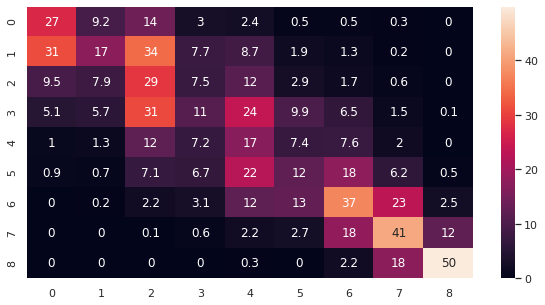

one_away_accuracy: 0.7561
balanced_accuracy_score: 0.3658
cohen_kappa_score: 0.2701
matthews_corrcoef: 0.2787
zero_one_loss: 0.6515
f1_score: 0.3219
precision_score: 0.378
recall_score: 0.3485
log_loss: 1.5319
roc_auc_score: 0.8309


In [42]:
# patience 3 2l neurons 512, batch 512, dropout 2 0.75, dropout 1 0.5, beta 1 0.9, beta 2 0.999, learning rate 0.007, PowerTransformer, patience 3, 1l 1024 neurons
print_conf_matrix(get_avg_cm_df(p_class))
print_output(cv_result)

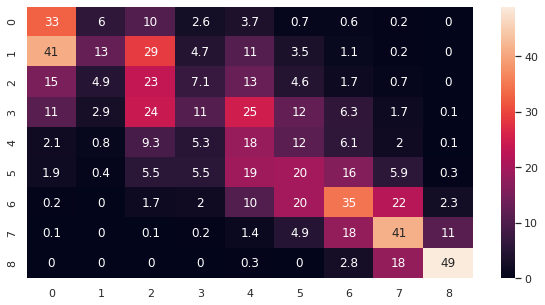

one_away_accuracy: 0.7489
balanced_accuracy_score: 0.3715
cohen_kappa_score: 0.2722
matthews_corrcoef: 0.281
zero_one_loss: 0.6514
f1_score: 0.3255
precision_score: 0.3868
recall_score: 0.3486
log_loss: 1.539
roc_auc_score: 0.8308


In [37]:
# patience 3 2l neurons 256, batch 512, dropout 2 0.75, dropout 1 0.5, beta 1 0.9, beta 2 0.999, learning rate 0.007, PowerTransformer, patience 3, 1l 512 neurons
print_conf_matrix(get_avg_cm_df(p_class))
print_output(cv_result)

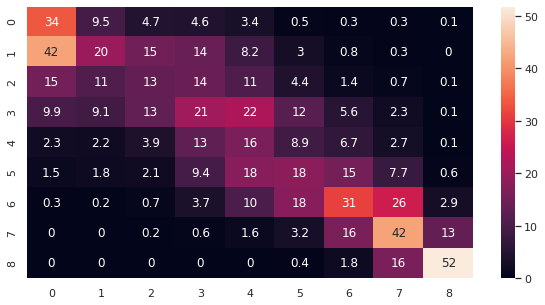

one_away_accuracy: 0.7439
balanced_accuracy_score: 0.3714
cohen_kappa_score: 0.276
matthews_corrcoef: 0.2822
zero_one_loss: 0.6452
f1_score: 0.3322
precision_score: 0.3745
recall_score: 0.3548
log_loss: 1.5308
roc_auc_score: 0.8312


In [24]:
# patience 3 2l neurons 256, batch 512, dropout 2 0.75, dropout 1 0.5, beta 1 0.9, beta 2 0.999, learning rate 0.007, PowerTransformer, patience 3, 1l 1024 neurons
print_conf_matrix(get_avg_cm_df(p_class))
print_output(cv_result)

In [363]:
def convert_nn_params(params):
    initializers = ['glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform', 'lecun_normal', 'lecun_uniform']
    activations = ['relu', 'elu', 'selu', 'sigmoid', 'tanh']

    get_float = lambda val: max(min(val, 1), 0)
    get_int = lambda val: int(round(val))
    get_initializer = lambda i: initializers[max(min(get_int(i), 5), 0)]
    get_activation = lambda i: activations[max(min(get_int(i), 4), 0)]

    return_params = {
        'hidden_layers': get_int(params['hidden_layers']),
        'adamax_learning_rate': max(params['adamax_learning_rate'], 0),
        'adamax_beta_1': get_float(params['adamax_beta_1']),
        'adamax_beta_2': get_float(params['adamax_beta_2']),
        'batch_size': get_int(params['batch_size']),
        'output_kernel_init': get_initializer(params['output_kernel_init']),
        'patience': get_int(params['patience']),
    }
    for l in range(1, get_int(params['hidden_layers'])+1):
        return_params[f'l{l}_neurons'] = get_int(params[f'l{l}_neurons'])
        return_params[f'l{l}_activation'] = get_activation(params[f'l{l}_activation'])
        return_params[f'l{l}_kernel_init'] = get_initializer(params[f'l{l}_kernel_init'])
        # return_params[f'l{l}_kernel_regularizer_l1'] = params[f'l{l}_kernel_regularizer_l1']
        # return_params[f'l{l}_kernel_regularizer_l2'] = params[f'l{l}_kernel_regularizer_l2']
        return_params[f'l{l}_dropout'] = get_float(params[f'l{l}_dropout'])

    return return_params

In [364]:
# Fine tune with bayes optimizator
def bayes_parameter_opt_nn_classification(X, y, init_round=15, opt_round=30, n_folds=10, patience=5, validation_size=0.05, output_process=False):
    def nn_eval(**params_raw):
        params = convert_nn_params(params_raw)
        p_proba, p_class, _ = get_classification_cv_predictions(create_and_fit_nn_with_params, X, y, 
            n_splits=10, patience=5, model_params=params, verbose=0, convert_y_categorical=True)
        cv_result = get_cv_multiclass_metrics(p_class, p_proba)
        print_output(cv_result)
        return cv_result['roc_auc_score']

    pbounds = {
        'adamax_learning_rate': (0.0005, 0.02),
        'adamax_beta_1': (0.8, 1),
        'adamax_beta_2': (0.95, 1),
        'output_kernel_init': (0, 5),
        'batch_size': (4, 512),
        'hidden_layers': (1, 2),
        'patience': (1,5),
    }
    for l in range(1, 3):
        pbounds[f'l{l}_neurons'] = (64, 1024)
        pbounds[f'l{l}_activation'] = (0, 4)
        pbounds[f'l{l}_kernel_init'] = (0, 5)
        pbounds[f'l{l}_dropout'] = (0.1, 0.8)
        # pbounds[f'l{l}_kernel_regularizer_l1'] = (0, 0.05)
        # pbounds[f'l{l}_kernel_regularizer_l2'] = (0, 0.05)

    bounds_transformer = SequentialDomainReductionTransformer()
    optimizer = BayesianOptimization(
        f = nn_eval, 
        pbounds = pbounds, 
        random_state=0,
        bounds_transformer=bounds_transformer,
    )
    optimizer.maximize(init_points=init_round, n_iter=opt_round)
    model_params=[]
    for model in range(len(optimizer.res)):
        model_params.append(optimizer.res[model]['target'])
    return {
        'target': optimizer.res[pd.Series(model_params).idxmax()]['target'], 
        'params': optimizer.res[pd.Series(model_params).idxmax()]['params'],
        'bounds_transformer': bounds_transformer,
        'optimizer': optimizer,
    }

In [368]:
print_output(params)

hidden_layers: 1
l1_neurons: 413
l1_activation: sigmoid
l1_dropout: 0.7217


In [366]:
%%time
lgb_optimized = bayes_parameter_opt_nn_classification(X, y, init_round=2, opt_round=150, n_folds=10)

|   iter    |  target   | adamax... | adamax... | adamax... | batch_... | hidden... | l1_act... | l1_dro... | l1_ker... | l1_neu... | l2_act... | l2_dro... | l2_ker... | l2_neu... | output... | patience  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


KeyboardInterrupt: 

In [365]:
%%time
lgb_optimized = bayes_parameter_opt_nn_classification(X, y, init_round=2, opt_round=150, n_folds=10)

m |  705.9    |  4.96     |  2.878    |
10 CV time: 102.16572165489197
one_away_accuracy: 0.7151
balanced_accuracy_score: 0.3389
cohen_kappa_score: 0.2417
matthews_corrcoef: 0.257
zero_one_loss: 0.6758
f1_score: 0.2739
precision_score: 0.3422
recall_score: 0.3242
log_loss: 1.608
roc_auc_score: 0.8227
|  53       |  0.8227   |  0.8821   |  1.0      |  0.007063 |  168.5    |  1.658    |  3.228    |  0.5991   |  5.0      |  979.7    |  1.231    |  0.736    |  3.763    |  706.1    |  4.959    |  2.894    |
10 CV time: 98.48741555213928
one_away_accuracy: 0.7255
balanced_accuracy_score: 0.3473
cohen_kappa_score: 0.2544
matthews_corrcoef: 0.2699
zero_one_loss: 0.6649
f1_score: 0.2908
precision_score: 0.3576
recall_score: 0.3351
log_loss: 1.5922
roc_auc_score: 0.8241
|  54       |  0.8241   |  0.8821   |  1.0      |  0.007065 |  166.9    |  1.658    |  3.228    |  0.599    |  5.0      |  981.1    |  1.232    |  0.7359   |  3.764    |  708.1    |  4.945    |  2.893    |
10 CV time: 103.3748104

KeyboardInterrupt: 

In [ ]:
|  69       |  0.8242   |  0.8824   |  1.0      |  0.007079 |  167.5    |  1.66     |  3.224    |  0.5979   |  5.0      |  980.2    |  1.239    |  0.7354   |  3.775    |  707.4    |  4.953    |  2.885    |

In [255]:
# Fine tune lgb binary classifier with hyperas
from hyperopt import Trials, STATUS_OK, tpe, rand
from hyperas import optim
from hyperas.distributions import choice, uniform
import json
import os

def get_data():
    with open(f'classification/multi_data_dropped_nan_filled.pickle', 'rb') as handle:
        data = pickle.load(handle)

    X_train, y_train, X_val, y_val, X_test, y_test = data['X_train'], data['y_train'], data['X_val'], data['y_val'], data['X_test'], data['y_test']
    X = pd.concat([X_train, X_test, X_val])
    y = np.concatenate([y_train, y_test, y_val])
    return X, y

    # adamax_learning_rate={{uniform(0.0005, 0.002)}}
    # adamax_beta_1={{uniform(0.8, 1)}}
    # adamax_beta_2={{uniform(0.95, 1)}}
    # output_kernel_init={{uniform(0,5)}}
    # batch_size={{uniform(4, 1024)}}
    # l1_kernel_init={{uniform(0,5)}}
    # l1_kernel_regularizer_l1={{uniform(0, 0.05)}}
    # l1_kernel_regularizer_l2={{uniform(0, 0.05)}}

def get_nn_hyperas_model(X, y):
    hidden_layers={{uniform(1, 3)}}

    l1_neurons={{uniform(64, 1024)}}
    l1_activation={{uniform(0, 4)}}

    l1_dropout={{uniform(0.1, 0.8)}}
    l2_neurons={{uniform(64, 1024)}}
    l2_activation={{uniform(0, 4)}}
    l2_dropout={{uniform(0.1, 0.8)}}
    l3_neurons={{uniform(64, 1024)}}
    l3_activation={{uniform(0, 4)}}
    l3_dropout={{uniform(0.1, 0.8)}}
   
    params_raw = {
        'hidden_layers': hidden_layers,
        # 'adamax_learning_rate': adamax_learning_rate,
        # 'adamax_beta_1': adamax_beta_1,
        # 'adamax_beta_2': adamax_beta_2,
        'l1_neurons': l1_neurons,
        'l1_activation': l1_activation,
        # 'l1_kernel_regularizer_l1': l1_kernel_regularizer_l1,
        # 'l1_kernel_regularizer_l2': l1_kernel_regularizer_l2,
        'l1_dropout': l1_dropout,
        'l2_neurons': l2_neurons,
        'l2_activation': l2_activation,
        'l2_dropout': l2_dropout,
        'l3_neurons': l3_neurons,
        'l3_activation': l3_activation,
        'l3_dropout': l3_dropout,
    }
    params = convert_nn_params(params_raw)
    print(params)
    p_proba, p_class, _ = get_classification_cv_predictions(create_and_fit_nn_with_params, X, y, 
        n_splits=10, patience=5, model_params=params, verbose=0, convert_y_categorical=True)
    cv_result = get_cv_multiclass_metrics(p_class, p_proba)
    print('\n\n *********************************')
    print_output(cv_result)
    print('*********************************\n\n')

    filename = 'nn_space/space.json'
    if not os.path.isfile(filename):
        with open(filename, 'a') as f:
            json.dump([], f)
    with open(filename, 'r') as f:
        log_file = json.load(f)
    log_file.append({'results': cv_result, 'space': })
    with open(filename, 'w') as f:
        json.dump(log_file, f)
    return {'loss': -cv_result['roc_auc_score'], 'status': STATUS_OK}

In [256]:
from sklearn.model_selection import KFold

best_run = None
best_model = None
space = None
trials=Trials()
best_run, best_model, space = optim.minimize(model=get_nn_hyperas_model,
                                      data=get_data,
                                      algo=tpe.suggest,
                                      max_evals=50,
                                      trials=trials,
                                      notebook_name='classification_nn_multi',
                                      eval_space=True,
                                      return_space=True,
                                      functions=[convert_nn_params, create_and_fit_nn_with_params, build_nn_model_with_params])




{'hidden_layers': 2, 'l1_neurons': 221, 'l1_activation': 'elu', 'l1_dropout': 0.1067002815900186, 'l2_neurons': 690, 'l2_activation': 'elu', 'l2_dropout': 0.7485956183290418}
split num: 1
Epoch 00006: early stopping
model fit time: 3.120809316635132
split num: 2
Epoch 00006: early stopping
model fit time: 2.6878392696380615
split num: 3
Epoch 00006: early stopping
model fit time: 2.626024007797241
split num: 4
Epoch 00006: early stopping
model fit time: 2.6142578125
split num: 5
Epoch 00006: early stopping
model fit time: 2.5979697704315186
split num: 6
Epoch 00006: early stopping
model fit time: 2.6726059913635254
split num: 7
Epoch 00006: early stopping
model fit time: 2.605379104614258
split num: 8
Epoch 00006: early stopping
model fit time: 2.6217689514160156
split num: 9
Epoch 00006: early stopping
model fit time: 2.56164288520813
split num: 10
Epoch 00006: early stopping
model fit time: 2.6841516494750977
10 CV time: 28.838220357894897


 *********************************
one_

In [257]:
print_output(convert_nn_params(best_run))

hidden_layers: 1
l1_neurons: 413
l1_activation: sigmoid
l1_dropout: 0.7217


In [258]:
filename = 'nn_space/space.json'
with open(filename, 'r') as f:
    log_file = json.load(f)

In [269]:
def get_metrics(f):
    metrics = {}
    for metric in f[0]['results']:
        metrics[metric] = [ex['results'][metric] for ex in f]
    metrics.pop('log_loss')
    return metrics

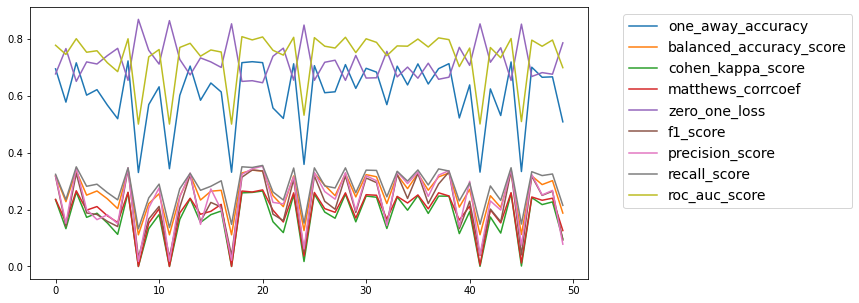

In [270]:
for metric in get_metrics(log_file):
    plt.plot(metrics[metric])
plt.legend(list(metrics.keys()), loc='upper left', bbox_to_anchor=(1.05, 1), prop={'size': 14})
plt.show()

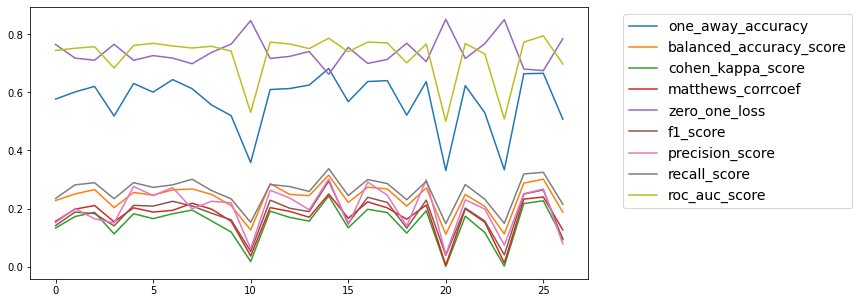

In [272]:
h2 = []
for ex in log_file:
    if ex['space']['hidden_layers'] == 2:
        h2.append(ex)
h2_metrics = get_metrics(h2)
for metric in h2_metrics:
    plt.plot(h2_metrics[metric])
plt.legend(list(h2_metrics.keys()), loc='upper left', bbox_to_anchor=(1.05, 1), prop={'size': 14})
plt.show()

In [284]:
log_file[max(range(len(h2)), key=lambda i: log_file[i]['results']['roc_auc_score'])]

{'results': {'one_away_accuracy': 0.715862316331074,
  'balanced_accuracy_score': 0.32833233027897546,
  'cohen_kappa_score': 0.2584230354122188,
  'matthews_corrcoef': 0.2648648786045853,
  'zero_one_loss': 0.6499618644766569,
  'f1_score': 0.3133130755925458,
  'precision_score': 0.32323537933419066,
  'recall_score': 0.35003813552334306,
  'log_loss': 1.6496958902032781,
  'roc_auc_score': 0.807146350266293},
 'space': {'hidden_layers': 1,
  'l1_neurons': 413,
  'l1_activation': 'sigmoid',
  'l1_dropout': 0.721739352112593}}

In [285]:
h2[max(range(len(h2)), key=lambda i: h2[i]['results']['roc_auc_score'])]

{'results': {'one_away_accuracy': 0.6660377397384522,
  'balanced_accuracy_score': 0.30133353277877567,
  'cohen_kappa_score': 0.22668253162155924,
  'matthews_corrcoef': 0.23973574446257842,
  'zero_one_loss': 0.6752331420373026,
  'f1_score': 0.26423691551696943,
  'precision_score': 0.26709563309883516,
  'recall_score': 0.3247668579626972,
  'log_loss': 1.655581472034663,
  'roc_auc_score': 0.7952506916189437},
 'space': {'hidden_layers': 2,
  'l1_neurons': 111,
  'l1_activation': 'tanh',
  'l1_dropout': 0.5690429358316548,
  'l2_neurons': 105,
  'l2_activation': 'elu',
  'l2_dropout': 0.36478380394095516}}